In [67]:
import pandas as pd
import graphlab as gl
import numpy as np
from IPython.core.display import display
from scipy.spatial.distance import cosine,euclidean,pdist,squareform,sqeuclidean
from sklearn.metrics.pairwise import pairwise_distances
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import entropy
from numpy.linalg import norm
from jenks import jenks
from itertools import chain,tee, izip
from urllib import unquote_plus
from titlecase import titlecase
from itertools import combinations
import itertools
import seaborn
from scikits.bootstrap import ci
import pyclust

In [9]:
# GLOBAL PARAMS
SESSION_THRESHOLD = 99e99 # 30 minutes
MIN_LENGTH = 5 # Minimum number of scrobbles in a patch

In [10]:
### Load some example data
fi = "../testData/mylistening.txt"
#fi = "../testData/test_listening_data.tsv"
me = pd.read_table(fi,header=None,
            names=['user_id','item_id','artist_id','ts'],parse_dates=['ts']).sort_values(by='ts')
### Build artist_name:artist_idx dict from 
artist_idx = {}
for line in open('../GenreModeling/data/vocab_idx'):
    line = line.strip().split('\t')
    artist_idx[line[0]] = int(line[1])
### Load artist feature matrix
features = np.load('../GenreModeling/data/features/lda_artists/features_190.npy')

In [11]:
### Build artist_id:artist_name and artist_name:artist_idx dicts from database data
artist_ids = {}
artist_names = {}
for line in open('../GenreModeling/data/artist_ids'):
    line = line.strip().split('\t')
    artist_ids[int(line[0])] = line[1]
    artist_names[line[1]] = int(line[0])
    
# Lookup function to get features for a given artist ID or artist name
def get_features(aid=None,artist_name=None):
    if artist_name is None:
        artist_name = artist_ids.get(aid)
        if not artist_name: 
            return np.repeat(np.nan,features.shape[1])
    return features[artist_idx[artist_name]]

# Function for Jensen Shannon Distance (Sqrt of Jensen Shannon Divergence)
def JSD(P, Q):
    if np.all(np.isnan(P)) or np.all(np.isnan(Q)):
        return np.nan
    _P = P / norm(P, ord=1)
    _Q = Q / norm(Q, ord=1)
    _M = 0.5 * (_P + _Q)
    return np.sqrt(np.clip(0.5 * (entropy(_P, _M) + entropy(_Q, _M)),0,1))

# Function to calculate distance between any two artists 
def calc_sim(artist1,artist2,metric='cosine'):
    if np.isnan(artist1) or np.isnan(artist2):
        return np.nan
    if artist1==artist2:
        return 0.0
    features1 = get_features(artist1)
    if np.all(np.isnan(features1)): return np.nan
    features2 = get_features(artist2)
    if np.all(np.isnan(features2)): return np.nan
    if metric == 'JSD':
        return JSD(features1,features2)
    elif metric == 'cosine':
        return cosine(features1,features2)
    elif metric == 'euclidean':
        return sqeuclidean(features1,features2)

# for proper formatting of artist names
def formatter(s):
    if s:
        try: return titlecase(unquote_plus(s))
        except: return s
    return 'UNKNOWN'

# Just a clean format for presenting example dataframes 
def pres_format(input_df):
    df = input_df.copy()
    df = df[['ts','artist_name','dist']].reset_index(drop=True)
    df.columns = ['timestamp','artist','distance']
    df['artist'] = df['artist'].apply(formatter)
#    df['previous artist'] = df['previous artist'].apply(formatter)
    return df

In [187]:
# All pre-formatting of data
new = me.copy()
new['artist_idx'] = new['artist_id'].apply(lambda x: artist_idx.get(artist_ids.get(x)))
new['before'] = new.shift(1)['artist_id']
new['td'] = new['ts']-new.shift(1)['ts']
new['td'] = new['td'].astype(int) / 10**9
new['artist_name'] = new.apply(lambda row: artist_ids.get(row['artist_id']),axis=1)
new['before_name'] = new.shift(1)['artist_name']
new = new[['ts','artist_id','before','td','artist_name','before_name']]
new['dist'] = new.apply(lambda row: calc_sim(row['artist_id'],row['before']),axis=1)
new['features'] = new['artist_name'].apply(lambda a: get_features(artist_name=a))
new = new.reset_index(drop=True)

In [13]:
### Add session index information
session_idx = 0
session_indices = []
for val in new['td']>=SESSION_THRESHOLD:
    if val:
        session_idx +=1
    session_indices.append(session_idx)
new['session'] = session_indices

### deletes session shorter than MIN_LENGTH
#session_counts = new['session'].value_counts()
#new = new[new['session'].isin(session_counts[session_counts>=MIN_LENGTH].index)]

In [14]:
### Get top artist info

top_artists = new['artist_id'].value_counts().reset_index()
top_artists.columns = ['artist_id','scrobbles']
top_artists['artist_name'] = top_artists['artist_id'].apply(lambda x: artist_ids.get(x))


In [15]:
### If we want to remove sessions with unknown artists (but let's not for now)
def remove_sessions_with_unknowns(df):
    if df['artist_name'].hasnans:
        return None
    else:
        return df
#new = new.groupby('session').apply(remove_sessions_with_unknowns).reset_index(drop=True)


In [16]:
### Add patch index information
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    a, b = tee(iterable)
    next(b, None)
    return izip(a, b)

s=20
dist_thresh = 0.2

def patch_segmenter(df,shuffle=True):
    l = df['artist_id']
    indices = list(np.array([len(list(v)) for g,v in itertools.groupby(l)][:-1]).cumsum())
    new_indices = []

    for b in indices:
        try:
            dist = cosine(df.iloc[b]['features'],df.iloc[b-1]['features'])
        except ValueError:
            dist = 1.
        #print b,test.iloc[b-1]['artist_name'],test.iloc[b]['artist_name'],dist
        if dist >= dist_thresh:
            new_indices.append(b)
    
    
    if new_indices:

        last_patch = False
        final_indices = []
        for i,(a,b) in enumerate(pairwise([0]+new_indices+[len(df)])):
            if b-a>=MIN_LENGTH:
                final_indices.append(a)
                last_patch = True
            else:
                if last_patch:
                    final_indices.append(a)
                last_patch = False
        
        return final_indices,new_indices
    return new_indices,new_indices
        
test = new.copy()
indices_shuffle = np.zeros(len(test),dtype=int)
indices_simple = np.zeros(len(test),dtype=int)
offset_shuffle = 0
idx_shuffle=0
offset_simple = 0
idx_simple=0

for session in test.groupby('session'):
    result_shuffle,result_simple = patch_segmenter(session[1])
    n=len(session[1])
    
    if len(result_shuffle)==0:
        indices_shuffle[offset_shuffle:offset_shuffle+n] = idx_shuffle
        idx_shuffle+=1
    else:
        indices_shuffle[offset_shuffle:offset_shuffle+result_shuffle[0]] = idx_shuffle
        idx_shuffle+=1
        for v, w in pairwise(result_shuffle):
            indices_shuffle[offset_shuffle+v:offset_shuffle+w] = idx_shuffle
            idx_shuffle+=1
        indices_shuffle[offset_shuffle+result_shuffle[-1]:offset_shuffle+result_shuffle[-1]+n] = idx_shuffle
        idx_shuffle+=1
    offset_shuffle += n

    if len(result_simple)==0:
        indices_simple[offset_simple:offset_simple+n] = idx_simple
        idx_simple+=1
    else:
        indices_simple[offset_simple:offset_simple+result_simple[0]] = idx_simple
        idx_simple+=1
        for v, w in pairwise(result_simple):
            indices_simple[offset_simple+v:offset_simple+w] = idx_simple
            idx_simple+=1
        indices_simple[offset_simple+result_simple[-1]:offset_simple+result_simple[-1]+n] = idx_simple
        idx_simple+=1
    offset_simple += n


    
if result_shuffle:
    indices_shuffle[offset_shuffle+result_shuffle[-1]:] = idx_shuffle
else:
    indices_shuffle[offset_shuffle:] = idx_shuffle
    
if result_simple:
    indices_simple[offset_simple+result_simple[-1]:] = idx_simple
else:
    indices_simple[offset_simple:] = idx_simple

test['patch_idx_shuffle'] = indices_shuffle
test['patch_idx_simple'] = indices_simple

In [17]:
# add artist block info
### https://stackoverflow.com/questions/14358567/finding-consecutive-segments-in-a-pandas-data-frame

test['block'] = (test['artist_id'].shift(1) != test['artist_id']).astype(int).cumsum()


In [86]:
# patch summary data methods

def patch_stats(df,agg_stats=True):
    first = df.iloc[0]
    n = len(df)
    start = first['ts']
    if agg_stats:
        artists = df['artist_id'].values
        if (n==1) or (len(df['artist_id'].unique())==1):
            centroid = first['features']
            if np.any(np.isnan(centroid)):
                diversity = np.nan
            else:
                diversity = 0.
        else:
            #diversity = (len(df['artist_id'].unique())/float(len(df))) * df['dist'][1:].mean()
            features = np.array([get_features(i) for i in df['artist_id']])
            centroid = np.nanmean(features,axis=0)
            diversity = np.nanmean(pdist(features,metric='cosine'))
            #diversity = (((len(df['artist_id'].unique())-1)/float(len(df)-1)) + df['dist'][1:].mean())/2.
            #centroid = np.nanmean([get_features(i) for i in df['artist_id']],axis=0)
        
        return pd.Series({'artists':df['artist_name'].values,'diversity':diversity,'centroid':centroid,'start_ts':start,'n':n})
    else:
        artist = first['artist_id']
        return pd.Series({'start_ts':start,'n':n,'artist_idx':artist})
    

basis = 'patch_idx_shuffle'
#basis = 'block'
if basis=='block': agg_stats=False
else: agg_stats = True
result = test.groupby(basis).apply(patch_stats,agg_stats)#.reset_index(level=1,drop=True)
result['start_idx'] = result['n'].cumsum().shift(1).fillna(0).astype(int)
    



In [110]:
pd.options.display.max_colwidth = 300
x = np.array([a for a in result[(result['diversity']<=0.2)&(result['n']>=MIN_LENGTH)]['centroid']])
n=3444000.
dists=squareform(pairwise_distances(x,metric='cosine'),checks=False)
print pairwise_distances(x,metric='cosine')[0]
result[(result['diversity']<=0.2)&(result['n']>=MIN_LENGTH)].iloc[1488]['artists']

[  2.10942375e-15   2.62132607e-01   3.00786723e-01 ...,   7.78344835e-01
   5.35706911e-01   8.26286910e-01]


array(['the+mars+volta', 'the+mars+volta', 'the+mars+volta',
       'the+mars+volta', 'the+mars+volta', 'the+mars+volta'], dtype=object)

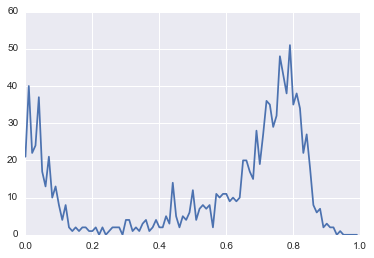

In [117]:
vals,bins = np.histogram(result[(result['n']>=5)&(result['diversity']>0)]['diversity'],bins = np.arange(0,1.01,0.01))
plt.plot(bins[:-1],vals)
#plt.gca().set_yscale('log')

In [ ]:
brks2 = jenks(result[result['n']>=5]['diversity'].dropna(),2)
brks3 = jenks(result[result['n']>=5]['diversity'].dropna(),3)
print brks2,brks3
#ax = seaborn.distplot(result[result['n']>=5]['diversity'].dropna(),norm_hist=False,bins=25)
ax = seaborn.distplot(result[(result['n']>=5)&(result['diversity']>0)]['diversity'].dropna(),bins=25)
# ax.axvline(brks2[1],c='k',ls='--')
# ax.axvline(brks3[1],c='r',ls='--')
# ax.axvline(brks3[2],c='r',ls='--')
#ax.axvline(brks[2],c='k',ls='--')
#ax.set_yscale('log')
ax.set_xlim(0,1);


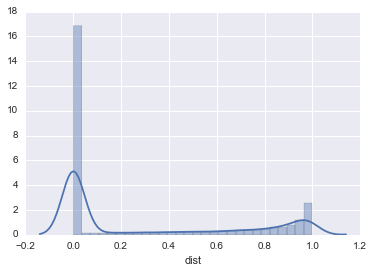

In [239]:
#seaborn.distplot(new['dist'][new['dist']>0],norm_hist=False)
seaborn.distplot(new['dist'].dropna())

In [4]:
def calc_dist(idx_1,idx_2,metric='cosine'):
    if np.isnan(idx_1) or np.isnan(idx_2):
        return np.nan
    features1 = features[idx_1]
    features2 = features[idx_2]

    if metric == 'JSD':
        return self.JSD(features1,features2)
    elif metric == 'cosine':
        return cosine(features1,features2)
    elif metric == 'euclidean':
        return euclidean(features1,features2)

randhop = pd.DataFrame({'a':np.random.randint(0,112312,100000000)})
randhop['prev'] = randhop['a'].shift(1)
randhop['dist'] = randhop.apply(lambda row: calc_dist(row['a'],row['prev']),axis=1)
#seaborn.distplot(randhop['dist'].dropna(),kde=False,norm_hist=False)

/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [18]:
result = []
blocks = test[['artist_id','block']].groupby('block').first()
for i in xrange(len(blocks)-100):
    first = blocks['artist_id'].iloc[i]
    result.append(np.array(blocks['artist_id'][i+1:i+101].apply(lambda val: calc_sim(val,first))))
    

In [28]:
def bootstrap(data, num_samples, statistic, alpha=0.05):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    samples = data[idx]
    stat = np.sort(statistic(samples, 1))
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])


CPU times: user 4.93 s, sys: 168 ms, total: 5.1 s
Wall time: 5.1 s
CPU times: user 7.65 s, sys: 2.68 s, total: 10.3 s
Wall time: 10.3 s


In [33]:
result_arr = np.vstack(result)
ci_lower = []
ci_upper = []
for i in xrange(result_arr.shape[1]):
    #lower,upper = ci(result_arr[:,i],statfunction=np.nanmean,n_samples=1000)
    lower,upper = bootstrap(result_arr[:,i],num_samples=1000,statistic=np.nanmean)
    ci_lower.append(lower)
    ci_upper.append(upper)

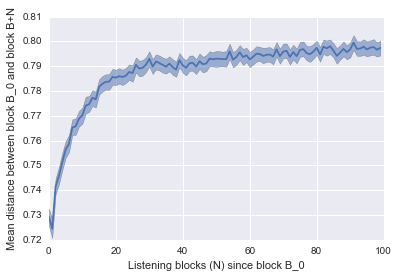

In [35]:
fig,ax = plt.subplots(1,1)
ax.plot(np.nanmean(result_arr,0))
ax.fill_between(xrange(100),ci_lower,ci_upper,alpha=0.5)
ax.set_xlabel('Listening blocks (N) since block B_0')
ax.set_ylabel('Mean distance between block B_0 and block B+N')

/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  if __name__ == '__main__':
/Users/jaredlorince/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  from ipykernel import kernelapp as app


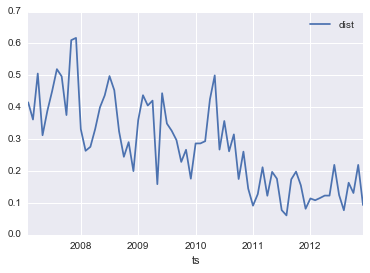

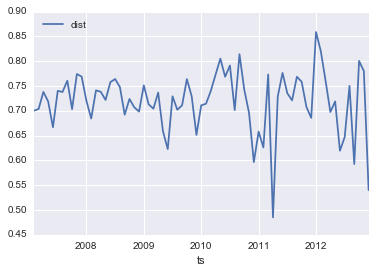

In [248]:
test[['ts','dist']].set_index('ts').resample('M',how='mean').plot()
test.groupby('block').first()[['ts','dist']].set_index('ts').resample('M',how='mean').plot()

In [138]:
pr = test[['artist_name','dist','block','patch_idx_shuffle','patch_idx_simple']][215:255].copy()
pr['artist_name'] = pr['artist_name'].apply(formatter)
#print pr.to_string(index=False)
pr['block'] = pr['block']-144
pr['patch_idx_shuffle'] = pr['patch_idx_shuffle']-8
pr['patch_idx_simple'] = pr['patch_idx_simple']-138
pr.columns = [['Artist','Distance','Block_idx','Shuffle_idx','Simple_idx']]
pr.reset_index(drop=True)[['Artist','Distance','Block_idx','Simple_idx','Shuffle_idx']]

,Artist,Distance,Block_idx,Simple_idx,Shuffle_idx
0,Sufjan Stevens,0.903825,0,0,0
1,The Offspring,0.974887,1,1,0
2,Beck,0.764417,2,2,0
3,Radiohead,0.176106,3,2,0
4,Sparta,0.746763,4,3,1
5,At the Drive-In,0.088306,5,3,1
6,At the Drive-In,0.000000,5,3,1
7,At the Drive-In,0.000000,5,3,1
8,At the Drive-In,0.000000,5,3,1
9,At the Drive-In,0.000000,5,3,1


In [240]:
def grouper(ser):
    if len(ser)<=1:
        return 0
    else:
        return pdist([a for a in ser]).mean()
div = test.dropna(subset=['artist_idx']).set_index('ts')['features'].resample('M').apply(grouper)
cnts = test.dropna(subset=['artist_idx']).set_index('ts')['features'].resample('M').count()


In [237]:
centroids = test.dropna(subset=['artist_idx']).set_index('ts')['features'].resample('W').apply(np.mean,axis=0)
centroids = pd.DataFrame({'centroid':centroids})
centroids['prev'] = centroids.shift(1)
centroid_dists = centroids.dropna().apply(lambda row: cosine(row['centroid'],row['prev']),axis=1)

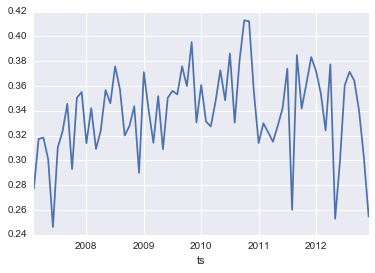

In [242]:
fig,ax = plt.subplots(1,1)
div.plot(ax=ax)
#centroid_dists.plot(ax=ax)